# Chapter 4: More Estimation
___

Table of contents:

1. [The Euro Problem](#euro)
2. [Summarizing the Posterior](#summarize)
3. [Swamping the priors](#swamp)
2. [Optimization](#opt)
2. [The Beta Distribution](#beta)

In [21]:
# I import the abstract type that I defined in notebook 2:
from think_bayes_modified import (Suite, percentile, credible_interval, 
                                  compare_posteriors_for_same_data)

import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
from typing import List, Tuple, Dict, Any

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. The Euro Problem  <a id="euro"></a>

When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. ‘It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. ‘If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.

But do these data give evidence that the coin is biased rather than fair?

To answer that question, we’ll proceed in two steps:
1. **Estimate the probability** that the coin lands face up.
2. Evaluate whether the **data support the hypothesis** that the coin is biased. (a little harder, dealt with in the next chapter)

Any given coin has some probability, x, of landing heads up when spun on edge. It seems reasonable to believe that the value of x depends on some physical characteristics of the coin, primarily the distribution of weight.

If a coin is perfectly balanced, we expect x to be close to 50%, but for a lopsided coin, x might be substantially different. We can use Bayes’s theorem and the observed data to estimate x.

Let’s define 101 hypotheses, where $H_x$ is the hypothesis that the probability of heads is $ x $ %, for values from 0 to 100. I’ll start with a uniform prior where the probability of Hx is the same for all x. We’ll come back later to consider other priors.

The likelihood function is relatively easy: If $H_x$ is true, the probability of heads is $ x / 100 $ and the probability of tails is $ 1 − x/100 $.

We define a class that has this likelihood in it. At first, we do not pay much attention to the appropriateness of the data structure used to represent head and tails, but later we will make some improvements to this implementation.

In [2]:
class Euro(Suite):
    """ class for the Euro problem """
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':  # heads
            return x / 100.0
        else:            # tails
            return 1 - x / 100.0

In [3]:
# after some coin tosses, I get these. I want to find out whether or not the coin is fair.
num_heads = 140
num_tails = 110

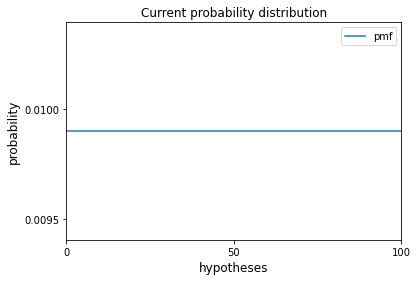

In [4]:
coin_flips = ['H'] * num_heads + ['T'] * num_tails  # observations
shuffle(coin_flips)  # in-place random mixing

hypotheses = range(0, 101)  # I consider 100 hypotheses, where H_i means that I assume P(H) = x %
suite = Euro(hypotheses)  # my prior will be uniform, and thus I start believing the coin is fair

suite.PlotProb();

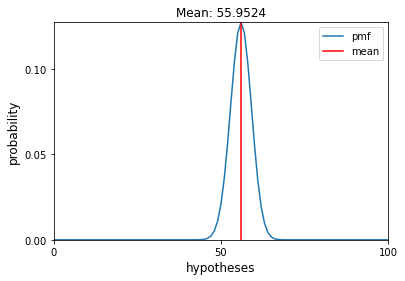

In [5]:
# update my prior witll all the observed coin flips
for flip in coin_flips:
    suite.Update(flip)
    
suite.PlotMean()

### 2. Summarizing the Posterior  <a id="summarize"></a>

Of course, there are several ways to summarize the posterior distribution. One option is to find the **most likely value in the posterior distribution**:

In [6]:
def max_likelihood(pmf):
    """Returns the value with the highest probability."""
    prob, val = max((prob, val) for val, prob in pmf.Items())
    return val

In [7]:
print("Max likelihood estimate is", max_likelihood(suite))
print(f"Proportion of heads is {num_heads} / ({num_tails} + {num_heads}), which coincides with "
      f"{num_heads * 100 / (num_heads + num_tails):.2f}%")

Max likelihood estimate is 56
Proportion of heads is 140 / (110 + 140), which coincides with 56.00%


In this case the result, 56, is also the observed percentage of heads, 140/250 = 56%. So that suggests (correctly) that the observed percentage is the maximum likelihood estimator for the population.

We might also summarize the posterior by computing the mean and median:

In [8]:
mean = suite.Mean()
median = percentile(suite, 50)
CI_90 = credible_interval(suite, percentage=90)

print(f"Mean: {mean:0.2f}")
print(f"median: {median}")
print(f"90%-CI: {CI_90}")

Mean: 55.95
median: 56
90%-CI: (51, 61)


Now, getting back to the original question, **we would like to know whether the coin is fair**. 

We observe that <font color="red"> the posterior credible interval does not include 50%, </font> which suggests that the coin is not fair. 

But ... <font color="red"> Does that **really** suggest that?</font>, or are we in state of confusion, mistaking _credible intervals_ for **reasonable evidence**?

Indeed we are, since with a CI we are not answering _exactly the question we started with_. We asked:
> "Do these data give evidence that the coin is biased rather than fair?" 

To answer that question, we will have to be more precise about what **it means to say that data constitute evidence for a hypothesis**. And that is the subject of the [next chapter](05_odds_and_addends.ipynb).

But before we go on, let's address one possible source of confusion. Since we want to know whether the coin is fair, it might be tempting to ask for the probability that x is 50%, right?

In [9]:
suite.Prob(50)

0.020976526129544672

The problem is that this 0.021, is almost **meaningless**. The decision to evaluate 101 hypotheses was arbitrary; we could have divided the range into more or fewer pieces, with the probability for any given hypothesis being greater or lower, respectively, depending on that chosen number.

### 3. Swamping the priors  <a id="swamp"></a>

We started with a uniform prior, but that might not be a good choice. I can believe that if a coin is lopsided, x might deviate substantially from 50%, but it seems unlikely that the Belgian Euro coin is so imbalanced that x is 10% or 90%.

It might be more reasonable to choose a prior that gives higher probability to values of x near 50% and lower probability to extreme values. And the simplest form of this prior is a "triangular" distribution with a peak at 50% and decaying linearly to both extremes, 0% and 100%. This in fact is a more reasonable prior because it somewhat encapsulates more knowledge about the real world, in this case, knowledge about the fact that a coin that is not fair but has at least the shape of a coin **imposes some limits** on the _mass distribution_ inside the coin, and that in turn imposes some limits on the _probability distribution_ of its possible outcomes. Namely, that **probabilities closer to 50% will be more likely that probabilities "far away" from 50%.**.

One way to express this general intuition mathematically is with the triangular prior:

$$
prior(x) = 
     \begin{cases}
       x        &\quad\text{ if } 0 <= x <= 50 \\
       100 - x  &\quad\text{ if } 50 > x >= 100
     \end{cases}
$$

Let's implement this prior:

In [42]:
class EuroTrianglePrior(Suite):
    """ Suite for solving the euro problem, with a more realistic triangle prior """
    def __init__(self, hypos):
        Suite.__init__(self)
        # but now override the prior as computed inside Suite, i.e., inside Pmf
        for x in range(0, 50 + 1):
            self.Set(x, x)  # left part of the triangle
        for x in range(50 + 1, 101):
            self.Set(x, 100 - x)
        self.Normalize()
        
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':  # heads
            return x / 100.0
        else:            # tails
            return 1 - x / 100.0

And now let's see how it compares with the prior we had before (the uniform prior). In order to do that, we first create a function that compares priors:

In [61]:
def compare_distributions(suites: List, labels=['prior1', 'prior2'], title=""):
    """
    Given a list of suites, plots each current distribution on the same plot, for comparison 
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    for suite, label in zip(suites, labels):
        suite_dict = suite.GetDict()
        ax.plot(suite_dict.keys(), suite_dict.values(), label=label)
        ax.autoscale(tight=True, axis='x')
        ax.set_title(f"Comparison of distributions\n{title}", fontsize=14)
        ax.set_xlabel("Possible values", fontsize=12); ax.set_ylabel("Probability (now)")
        ax.legend(fontsize=11)

Now we define two suites that have still not seen any data, and visualize them

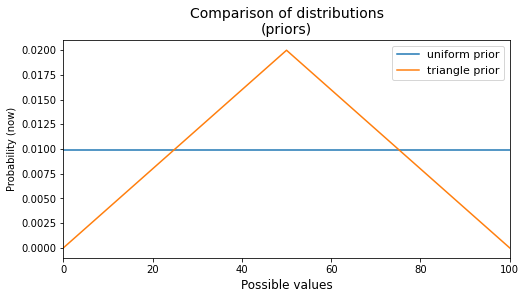

In [65]:
suite_triangle_prior = EuroTrianglePrior(hypotheses)
suite_uniform_prior = Euro(hypotheses)

compare_distributions(suites=[suite_uniform_prior, suite_triangle_prior], 
                      labels=['uniform prior', 'triangle prior'],
                      title="(priors)")

Now it would be interesting to see how similar the posteriors are for the two models, when they see the same data:

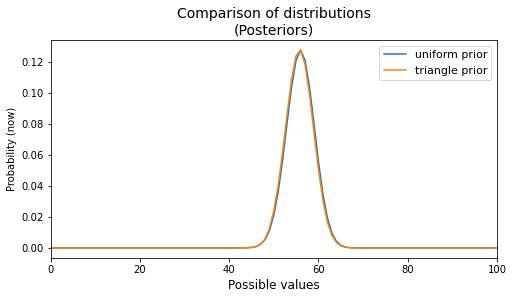

In [66]:
for flip in coin_flips:
    suite_uniform_prior.Update(flip)
    suite_triangle_prior.Update(flip)
    
compare_distributions(suites=[suite_uniform_prior, suite_triangle_prior],
                      labels=['uniform prior', 'triangle prior'],
                      title='(Posteriors)')

In [67]:
def summary_distributions(suites: List, labels=['prior1', 'prior2']):
    """ Given a list of suites, prints out relevant point estimates for each suite """
    for suite, label in zip(suites, labels):
        mean = suite.Mean()
        median = percentile(suite, 50)
        CI_90 = credible_interval(suite, 90)
        print(f"\n{'---'*20}\nSummary for suite: {label}\n"
               f" - Mean: {mean:0.2f}\n - Median: {median}\n - 90%-CI: {CI_90}")

In [68]:
summary_distributions(suites=[suite_uniform_prior, suite_triangle_prior],
                      labels=['uniform prior', 'triangle prior'])


------------------------------------------------------------
Summary for suite: uniform prior
 - Mean: 55.95
 - Median: 56
 - 90%-CI: (51, 61)

------------------------------------------------------------
Summary for suite: triangle prior
 - Mean: 55.74
 - Median: 56
 - 90%-CI: (51, 61)


Even with **substantially different priors, the posterior distributions are very similar**. The medians and the credible intervals are identical; the means differ by less than 0.5%.

This is an example of **swamping the priors: with enough data, people who start with different priors will tend to converge on the same posterior**.

### 3. Optimization  <a id="opt"></a>

The code developed so far is meant to be easy to read, but it is not very efficient. For this example, if we care about run time, there are several ways we can speed it up.

The first opportunity is to reduce the number of times we normalize the suite. In the original code, we call Update once for each spin. Each update iterates through the hypotheses, then calls Normalize, which iterates through the hypotheses again. We can save some time by doing all of the updates before normalizing, like with the new method `UpdateSet`:

In [69]:
class Euro(Euro):
    def UpdateSet(self, dataset):
            for data in dataset:
                for hypo in self.Values():
                    like = self.Likelihood(data, hypo)
                    self.Mult(hypo, like)
            return self.Normalize()

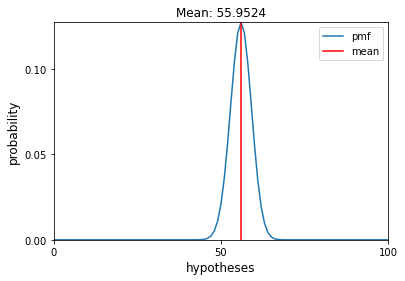

In [71]:
suite_new = Euro(hypotheses)
suite_new.UpdateSet(coin_flips)  # we can use the whole dataset at once
suite_new.PlotMean()

Let's compare the run times, to see if there exists a significant difference:

In [77]:
%%timeit  # slow (original) version
suite_new = Euro(hypotheses)
for flip in coin_flips:
    suite_new.Update(flip)

15.1 ms ± 889 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
%%timeit  # less slow (current) version
suite_new = Euro(hypotheses)
suite_new.UpdateSet(coin_flips)  # we can use the whole dataset at once

10.7 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From 15.1ms to 10.7ms we are talking about a 41% increase in speed, so that's something, although the run time is still proportional to the amount of data. We can speed things up even more by rewriting Likelihood to process the entire dataset, rather than one spin at a time. To do this, we first need to **reformulate how we are going to store our dataset** so we can divise a **more efficient of useful manner.**

In the original version, data is a string that encodes either heads or tails. As an alternative, we could encode the dataset as a tuple of two integers: the number of heads and tails. In that case Likelihood looks like this:

In [82]:
print(num_heads, num_tails)

140 110


Now we need to modify the likelihood method so that it can handle this new data encoding:

In [83]:
class EuroNew(Euro):
    """ Class with new encoding of observations """
    def Likelihood(self, data, hypo):
        x = hypo / 100.0  # probability represented by hypo
        heads, tails = data
        likelihood = x**heads * (1 - x)**tails  # TODO: This can't be right
        return likelihood

In [86]:
dataset = (num_heads, num_tails)
suite_new2 = EuroNew(hypotheses)
suite_new2.Update(dataset)

2.6088321798736822e-76

### 3. The Beta Distribution  <a id="beta"></a>